<a href="https://colab.research.google.com/github/jaydeepthik/keras-GAN/blob/master/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
tf.__version__

'2.7.0'

In [3]:
! pip install imageio
! pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-81zin630
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-81zin630
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=173744 sha256=713f3e7c293cced2d8a17a95b789d1743b1596b8d54aaaf67dcea35b06d38c71
  Stored in directory: /tmp/pip-ephem-wheel-cache-6a8y8ofy/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [5]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32")
train_images = (train_images - 127.5)/127.5

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [8]:
def get_generator():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100, )))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256)

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh"))
  assert model.output_shape == (None, 28, 28, 1)

  return model



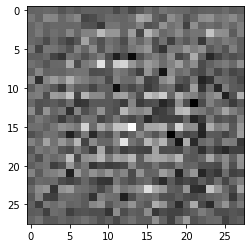

In [9]:
generator = get_generator()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0,:,:, 0], cmap="gray")

In [12]:
def get_discriminator():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                    input_shape=[28, 28, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))

  return model

In [13]:
descriminator = get_discriminator()

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
def descriminator_loss(real_outputs, fake_outputs):
  real_loss = cross_entropy(tf.ones_like(real_outputs), real_outputs)
  fake_loss = cross_entropy(tf.zeros_like(fake_outputs), fake_outputs)

  return real_loss, fake_loss

def generator_loss(fake_outputs):
  return cross_entropy(tf.ones_like(fake_outputs), fake_outputs)

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
descriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [18]:
#training loop

EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as desc_tape:
    generated_images = generator(noise, training=True)

    real_outputs = descriminator(images, training=True)
    fake_outputs = descriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_outputs)
    disc_loss = descriminator_loss(real_outputs, fake_outputs)

  generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
  descriminator_gradients = desc_tape.gradient(disc_loss, descriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
  descriminator_optimizer.apply_gradients(zip(descriminator_gradients, descriminator.trainable_variables))

In [20]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

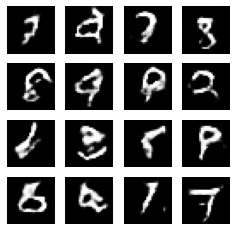

In [21]:
train(train_dataset, EPOCHS)

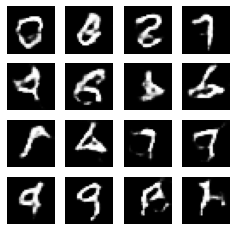

In [25]:
seed_ = tf.random.normal([num_examples_to_generate, noise_dim])
generate_and_save_images(generator,
                              1,
                             seed_)

-1.0
